<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/richness_of_vlPFC_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# Richness of visual representations in the vlPFC
-----------------------------------------------------------------------------
#### This notebook replicates the analysis measuring the presence of perceptual dimensions in the early and late visual responses the vlPFC
----


---
###Please ensure you have downloaded the required data from Figshare before proceeding.

**Google Colab:**



*   Upload the data to your Google Drive.
*   Select Google Drive in the widget below and mount your drive for the fastest access.




**Kaggle:**

*   Add the dataset to your notebook's Input directory (e.g., ../input/dataset-name).

*   Select Kaggle Input in the widget below.

**Local Computer:**

*   Store the downloaded files in a folder on your machine.

*   Select Local Storage in the widget below and paste the absolute path to that folder (e.g., /Users/name/data/).

In [ ]:
# ──────────────────────────────────────────────────────────────────────
# DATA SETUP WIDGET (Universal: Colab, Kaggle & Local)
# ──────────────────────────────────────────────────────────────────────
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import shutil
from pathlib import Path

# --- 1. CONFIGURATION
REQUIRED_FILES = [
    'Spike_count_even_sessions.npy',
    'Spike_count_odd_sessions.npy',
    'hvm_public_extended_meta.csv',
    'deepNetFeatures_landscape.zip'
]
DEST_DIR = Path("downloads")
DEST_DIR.mkdir(exist_ok=True)

# Detect Environment
IN_COLAB = 'google.colab' in str(get_ipython())
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

# --- UI Elements ---
style = {'description_width': '120px'}
layout_full = widgets.Layout(width='98%')

header = widgets.HTML("<h2>📂 Data Import Manager</h2>")

# Determine options based on environment
options = ['Local Upload']
if IN_COLAB:
    options = ['Google Drive', 'Local Upload']
elif IN_KAGGLE:
    options = ['Kaggle Input', 'Local Upload']
else:
    options = ['Local Storage', 'Local Upload']

source_toggle = widgets.ToggleButtons(
    options=options,
    description='Select Source:',
    button_style='info',
    style=style
)

# Input for Paths
path_input = widgets.Text(
    value='/content/drive/MyDrive/vlPFC_Geometry' if IN_COLAB else '.',
    placeholder='Enter absolute path to data folder...',
    description='Data Path:',
    disabled=False,
    layout=layout_full,
    style=style
)

btn_action = widgets.Button(
    description='Start Import',
    button_style='primary',
    icon='download',
    layout=widgets.Layout(width='200px')
)

out_log = widgets.Output(layout={'border': '1px solid #ddd', 'padding': '10px'})

# --- Logic ---
def update_ui(change):
    if source_toggle.value == 'Local Upload':
        path_input.layout.display = 'none'
    else:
        path_input.layout.display = 'flex'
        if source_toggle.value == 'Google Drive':
            path_input.description = 'Drive Path:'
        elif source_toggle.value == 'Local Storage':
            path_input.description = 'Local Path:'
        elif source_toggle.value == 'Kaggle Input':
            path_input.description = 'Input Path:'
            path_input.value = '/kaggle/input/vlpfc-geometry'

source_toggle.observe(update_ui, 'value')

def on_click_action(b):
    with out_log:
        clear_output()
        mode = source_toggle.value

        if mode == 'Local Upload':
            if IN_COLAB:
                from google.colab import files
                print("🚀 Upload files now (select all required files):")
                uploaded = files.upload()
                for name in uploaded:
                    shutil.move(name, DEST_DIR / name)
                print("\n✅ Upload complete.")
            else:
                print("⚠️ Manual upload widget is Colab-only.")
                print(f"👉 Please manually copy files to: {DEST_DIR.absolute()}")
            return

        src_path = Path(path_input.value)
        if mode == 'Google Drive' and not src_path.exists():
            from google.colab import drive
            print("🔄 Mounting Google Drive...")
            drive.mount('/content/drive')

        if not src_path.exists():
            print(f"❌ Error: Path not found: {src_path}")
            return

        print(f"🔎 Scanning {src_path} for files...")
        for fname in REQUIRED_FILES:
            dest = DEST_DIR / fname
            if dest.exists():
                print(f"   • {fname}: Already exists (Skipping)")
                continue

            found = list(src_path.rglob(fname))
            if found:
                print(f"   • Copying {fname}...", end=" ")
                shutil.copy(found[0], dest)
                print("Done.")
            else:
                print(f"   ❌ {fname}: Not found in source path.")

        missing = [f for f in REQUIRED_FILES if not (DEST_DIR / f).exists()]
        if not missing:
            print("\n🎉 Success! All files are in 'downloads/'. Run the next cell.")
        else:
            print(f"\n⚠️ Missing files: {missing}")

update_ui(None)
btn_action.on_click(on_click_action)
display(header, source_toggle, path_input, btn_action, out_log)

# Analysis

In [2]:

import warnings
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from matplotlib import colors as mcolors
from PIL import Image
import cv2
import time
import re
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import sys
import glob

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

IN_COLAB = False
IN_KAGGLE = False
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass
if not IN_COLAB:
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
        IN_KAGGLE = True

# Determine the path to the repository based on the environment
if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils')) # Add the utils directory to sys.path

from utils.extract_and_download_data import unzip
from utils.analysis_utils import (spearman_corr_ranked, rank_data, robust_rdm, rank_data_batch)
from utils.plotting_utils import q_to_stars

# -------------------------------------------------------------------
# Analysis Script
# -------------------------------------------------------------------

print("Analysis Script start")

# Global parameters
N_PERM        = 10000
PERM_CHUNK    = 2000
N_BATCH_RANK  = 500
RNG = np.random.default_rng(42)

FIGURES_DIR   = Path("Figures")
STATISTICS_DIR = Path("Statistics")
DATA_FNAME    = STATISTICS_DIR / "rsa_results.npz"

# -------------------------------------------------------------------
# Data Setup handled by Widget previously
# -------------------------------------------------------------------
DOWNLOAD_DIR = Path("downloads")

zip_path = DOWNLOAD_DIR / "deepNetFeatures_landscape.zip"
if zip_path.exists():
     unzip(str(zip_path), "deepNetFeatures_landscape")
else:
     print(f"Warning: {zip_path} not found. Ensure you ran the widget.")

# -------------------------------------------------------------------
# Load spike counts & metadata
print("Loading spike counts & metadata …")
spike_counts_even = np.load("downloads/Spike_count_even_sessions.npy",
                            allow_pickle=True)
spike_counts_odd  = np.load("downloads/Spike_count_odd_sessions.npy",
                            allow_pickle=True)
spike_counts = (spike_counts_even + spike_counts_odd) / 2.0
meta         = pd.read_csv("downloads/hvm_public_extended_meta.csv")

EARLY_SLICE = slice(5, 9)    # 50–90 ms
LATE_SLICE  = slice(10, 20)  # 100–200 ms
slices = [EARLY_SLICE, LATE_SLICE]

hv_idx    = np.where(meta["rxz"] != 0)[0]
cat_codes = meta["category_name"].astype("category").cat.codes.to_numpy()
obs_hv, perm_hv = np.zeros(2), np.zeros((N_PERM, 2))

print("Face feature models …")
face_idx = np.where((meta["rxz"] != 0) &
                    (meta["category_name"] == "Faces"))[0]
faces    = meta.loc[face_idx]

orient    = faces[["rxy_semantic","rxz_semantic","ryz_semantic"]].to_numpy(float)
size_feat = faces["s"].to_numpy(float)[:, None]
pos       = faces[["centroid_y","centroid_x"]].to_numpy(float)
pos       = (pos - 128.0) / 256.0 * 8.0
ang       = np.arctan2(pos[:,1], pos[:,0])
pos_vec   = np.c_[np.cos(ang), np.sin(ang)]

obs_face  = {k: np.zeros(2)       for k in ["orient","size","pos"]}
perm_face = {k: np.zeros((N_PERM,2)) for k in ["orient","size","pos"]}

for key, feat in [("orient", orient), ("size", size_feat), ("pos", pos_vec)]:
    for w, sl in enumerate(slices):
        neu   = spike_counts[face_idx, :, sl].reshape(len(face_idx), -1)
        r_neu = rank_data(pdist(neu, "euclidean"))
        dist  = "cosine" if key == "orient" else "euclidean"
        r_feat = rank_data(pdist(feat, dist)) if key == "orient" else \
                 rank_data(pdist(feat, dist))
        obs_face[key][w] = spearman_corr_ranked(r_neu, r_feat)

        Xc, dc = r_neu - r_neu.mean(), np.linalg.norm(r_neu - r_neu.mean())
        for p_start in range(0, N_PERM, PERM_CHUNK):
            p_end = min(p_start + PERM_CHUNK, N_PERM)
            sz    = p_end - p_start
            perms = np.stack([
                rank_data(pdist(feat[RNG.permutation(len(feat))], dist))
                for _ in range(sz)
            ], axis=1)
            Y = perms - perms.mean(0)
            perm_face[key][p_start:p_end, w] += (Xc[:, None] * Y).sum(0) / dc / \
                                               np.sqrt((Y**2).sum(0))

print("In-paint RSA …")
# unzip likely already done above, but keeping for safety if reused logic requires it,
# though here we moved it up. The original code had unzip call here.
# We will keep the unzip call here commented out or removed if we did it earlier.
# Actually, the logic above does it.

def load_all(mode):
    paths = sorted(
        glob.glob(f"deepNetFeatures_landscape/*CLIP*features_{mode}.pkl"))
    feats, names = [], []
    for pkl in paths:
        with open(pkl, "rb") as f:
            d = pickle.load(f)
        feats.append(d["penultimate"].reshape(d["penultimate"].shape[0], -1))
        names.append(pd.Index(d["image_names"]))
    common = names[0]
    for nm in names[1:]:
        common = common.intersection(nm)
    common = common.sort_values()
    idxs   = [nm.get_indexer(common) for nm in names]
    return common, [f[i] for f, i in zip(feats, idxs)]

common, feats_list = load_all("inpainted_images_original")
idx_c      = pd.Index(meta["image_id"].str.strip()).get_indexer(common)
sc_inpaint = spike_counts[idx_c]
meta_in    = meta.set_index("image_id").loc[common].reset_index()

results = {}
for key, sl in zip(["Early","Late"], slices):
    neural = sc_inpaint[:, :, sl].reshape(sc_inpaint.shape[0], -1)
    obs, perm = [], []
    for obj in meta_in["object_name"].unique():
        idx_o = np.where(meta_in["object_name"] == obj)[0]
        if len(idx_o) < 3:
            continue
        r_neu = rank_data(pdist(neural[idx_o], "euclidean"))
        r_inp = robust_rdm([f[idx_o] for f in feats_list])
        obs.append(spearman_corr_ranked(r_neu, r_inp))

        Xc, dc = r_neu - r_neu.mean(), np.linalg.norm(r_neu - r_neu.mean())
        perm_vals = np.zeros((len(r_neu), N_PERM))
        for p_start in range(0, N_PERM, PERM_CHUNK):
            p_end = min(p_start + PERM_CHUNK, N_PERM)
            for j in range(p_start, p_end):
                perm_idx = RNG.permutation(len(idx_o))
                perm_vals[:, j] = rank_data(
                    pdist(neural[idx_o][perm_idx], "euclidean"))
        perm_ranked = rank_data_batch(perm_vals, N_BATCH_RANK)
        perm.append([spearman_corr_ranked(perm_ranked[:, j], r_inp)
                     for j in range(N_PERM)])
    results[key] = {"obs": np.mean(obs),
                    "null": np.mean(np.vstack(perm), axis=0)}

# -------------------------------------------------------------------
# Save everything
STATISTICS_DIR.mkdir(exist_ok=True)
np.savez_compressed(
    DATA_FNAME,
    face_orient_obs=obs_face['orient'],
    face_orient_perm=perm_face['orient'],
    face_size_obs=obs_face['size'], face_size_perm=perm_face['size'],
    face_pos_obs=obs_face['pos'],  face_pos_perm=perm_face['pos'],
    inpaint_obs=np.array([results['Early']['obs'],
                          results['Late']['obs']]),
    inpaint_perm=np.column_stack([results['Early']['null'],
                                  results['Late']['null']])
)
print("Analysis complete – results saved.")


Analysis Script start
Unzipping downloads/deepNetFeatures_landscape.zip...
Unzip successful.
Loading spike counts & metadata …
Face feature models …
In-paint RSA …
Analysis complete – results saved.


# Plot results

Plotting Script start
saved → Figures/all_rsa_panels_rotated_shared_x.svg


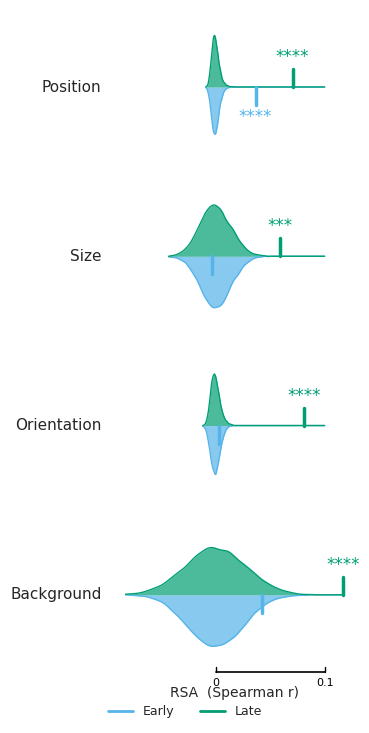

In [3]:
# -------------------------------------------------------------------
# Plotting Script
# -------------------------------------------------------------------

print("Plotting Script start")

from scipy.stats import gaussian_kde
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.lines import Line2D


PALETTE = {                            # Okabe–Ito, safe for red-green color blind
    "Early":   "#56B4E9",
    "Late": "#009E73"
}
WANT = [
    ("Position",    "face_pos_obs",    "face_pos_perm"),
    ("Size",        "face_size_obs",   "face_size_perm"),
    ("Orientation", "face_orient_obs", "face_orient_perm"),
    ("Background",  "inpaint_obs",     "inpaint_perm"),
]
sns.set_style("white")

def q_to_stars(q):
    return "****" if q < 1e-4 else "***" if q < 1e-3 else "**" if q < 1e-2 else "*" if q < .05 else ""

# ───────── helper to draw ONE panel ─────────
def plot_rotated_density_panel(ax, title_text, obs_rsa, perm_rsa,
                               p_fdr_early, p_fdr_late, is_last):
    """Rotated violin-style density: negative y = Early, positive y = Late."""
    perm_early, perm_late = perm_rsa[:, 0], perm_rsa[:, 1]

    # KDE grid restricted to dense region **AND** forced to include observed values & baseline end-points
    comb = np.concatenate([perm_early, perm_late])
    lo, hi = np.percentile(comb, [.1, 99.9])
    pad = (hi - lo) * 0.02
    xmin = min(lo - pad, obs_rsa.min(), 0)          # include 0 for baseline
    xmax = max(hi + pad, obs_rsa.max(), 0.10)       # include 0.10 for baseline
    x_grid = np.linspace(xmin, xmax, 400)

    dens_e = gaussian_kde(perm_early)(x_grid)
    dens_l = gaussian_kde(perm_late )(x_grid)

    # zero tiny tails
    dens_e[dens_e < 0.005 * dens_e.max()] = 0
    dens_l[dens_l < 0.005 * dens_l.max()] = 0
    max_d = max(dens_e.max(), dens_l.max(), 1e-8)

    # -- densities
    ax.fill_between(x_grid, -dens_e, 0,  color=PALETTE["Early"], alpha=0.7, lw=0)
    ax.plot(x_grid, -dens_e,              color=PALETTE["Early"], lw=1)
    ax.fill_between(x_grid, 0,  dens_l,   color=PALETTE["Late"],  alpha=0.7, lw=0)
    ax.plot(x_grid,  dens_l,              color=PALETTE["Late"],  lw=1)

    # observed vertical bars (never clipped now)
    bar_len = 0.35 * max_d
    ax.plot([obs_rsa[0]]*2, [0, -bar_len], color=PALETTE["Early"], lw=2.5, zorder=3, clip_on=False)
    ax.plot([obs_rsa[1]]*2, [0,  bar_len], color=PALETTE["Late"],  lw=2.5, zorder=3, clip_on=False)
    # significance stars
    star_pad = 0.06 * max_d             # 6 % of full density height

    # Plot star for Early
    s_early = q_to_stars(p_fdr_early)
    if s_early:
        y_bar_end_early = -bar_len
        y_star_early    = y_bar_end_early - star_pad
        ax.text(obs_rsa[0], y_star_early, s_early, ha='center',
                va='top', fontsize=12, color=PALETTE["Early"], zorder=5)

    # Plot star for Late
    s_late = q_to_stars(p_fdr_late)
    if s_late:
        y_bar_end_late = bar_len
        y_star_late    = y_bar_end_late + star_pad
        ax.text(obs_rsa[1], y_star_late, s_late, ha='center',
                va='bottom', fontsize=12, color=PALETTE["Late"], zorder=5)


    # panel label on the left
    ax.set_ylabel(title_text, fontsize=11, rotation=0,
                  ha='right', va='center')
    ax.yaxis.set_label_coords(-0.11, 0.5)

    # tidy appearance
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-max_d*1.5, max_d*1.5)
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)

    # baseline + custom ticks ONLY on last subplot
    if is_last:
        y0 = ax.get_ylim()[0]
        tick_len = 0.25 * bar_len
        ax.plot([0, 0.10], [y0, y0], color='black', lw=1.2, clip_on=False, zorder=10)
        for xt in [0, 0.10]:
            ax.plot([xt, xt], [y0, y0 + tick_len], color='black', lw=1, clip_on=False, zorder=10)
            ax.text(xt, y0 - tick_len*1.2, f"{xt:0.2g}", ha='center', va='top',
                    fontsize=8, color='black', zorder=10)

        ax.set_xlabel("RSA  (Spearman r)", labelpad=10)
# ------------------------------------------------------------------


# ───────── load & prepare data ─────────
DATA_FNAME = os.path.join("Statistics", "rsa_results.npz")
dat = np.load(DATA_FNAME, allow_pickle=True)

valid = []
for title, ok, pk in WANT:
    if ok in dat and pk in dat:
        obs, perm = dat[ok], dat[pk]
        if obs.shape == (2,) and perm.ndim == 2 and perm.shape[1] == 2:
            valid.append((title, obs, perm))

if not valid:
    raise RuntimeError("No valid RSA metrics in file.")

# raw p-values then FDR
raw_ps_early = [(perm[:,0] >= obs[0]).mean() for _,obs,perm in valid]
raw_ps_late  = [(perm[:,1] >= obs[1]).mean() for _,obs,perm in valid]

_, qvals_early = fdrcorrection(raw_ps_early, alpha=0.05, method='indep')
_, qvals_late  = fdrcorrection(raw_ps_late, alpha=0.05, method='indep')

# ───────── figure ─────────
fig_h = max(2.5, 1.8 * len(valid))
fig, axes = plt.subplots(len(valid), 1, figsize=(3.8, fig_h),
                         tight_layout=True, sharex=True)
if len(valid) == 1:
    axes = [axes]

for i, (ax, (title, obs, perm)) in enumerate(zip(axes, valid)):
    plot_rotated_density_panel(ax, title, obs, perm,
                               p_fdr_early=qvals_early[i],
                               p_fdr_late=qvals_late[i],
                               is_last=(i == len(axes)-1))

# global legend (below all panels, outside plot)
legend_elems = [Line2D([0],[0], color=PALETTE['Early'], lw=2, label='Early'),
                Line2D([0],[0], color=PALETTE['Late'],  lw=2, label='Late')]
fig.legend(handles=legend_elems,
           loc='lower center', bbox_to_anchor=(0.5, -0.02),
           ncol=2, frameon=False, fontsize=9)

# save
os.makedirs("Figures", exist_ok=True)
out_path = Path("Figures") / "all_rsa_panels_rotated_shared_x.svg"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"saved → {out_path}")

# Download figures and statistics

In [4]:
import os
from google.colab import files

# Define the directories to zip
directories_to_zip = ["Figures", "Statistics"]
zip_filename = "results_RSA_models.zip"

# Check if directories exist before zipping
existing_directories = [d for d in directories_to_zip if os.path.exists(d)]

if existing_directories:
    # Create a zip archive of the specified directories
    zip_command = f"zip -r {zip_filename} {' '.join(existing_directories)}"
    os.system(zip_command)

    # Provide a download link for the zip file
    if os.path.exists(zip_filename):
        print(f"Created {zip_filename}")
        files.download(zip_filename)
    else:
        print(f"Failed to create {zip_filename}.")
else:
    print("Neither the 'Figures' nor the 'Statistics' directory was found.")

Created results_RSA_models.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>